## Joint GRAPPA g factor demo 
###### Author: Zimu Huo
###### Date: 07.2022

I will skip the details of GRAPPA. 

bSSFP suffers from unique banding artifacts, which are commonly corrected by using multiple phase cycles. These banding artifacts are a form of spatial modulation. While it is tricky to exploit this with SENSE, this additional redundancy can be easily utilized by GRAPPA. To achieve this, we simply extend the GRAPPA kernel to include the phase cycle dimensions.


In [1]:
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
from util.jg import *
from joblib import Parallel, delayed

In [2]:
data = np.load("../lib/ssfp_pc8.npy")
rawImage = ifft2c(data)
rawImage = rawImage / np.max(rawImage)
data = fft2c(rawImage)
truth = rsos(rsos(rawImage,-1),-1)
[ny, nx, pc, nc] = data.shape
acs = simulate.acs(data, (32, 32))
dataR = np.zeros(data.shape, dtype = complex)
R = 2
dataR[::R] = data[::R]
mask = np.sign(abs(dataR))

In [3]:
def gaussian_noise(shape, mu = 0, sigma = 1):
    n = np.zeros(shape, dtype = complex)
    n.real = np.random.normal(mu, sigma, np.prod(shape)).reshape(shape)
    n.imag = np.random.normal(mu, sigma, np.prod(shape)).reshape(shape)
    return n

In [4]:
rep = 50
R = 4
noise_power = 0.00001
pseudodata = np.zeros([ny, nx, rep], dtype = complex)
w = joint_grappa_weights(acs, R, kh = 4, kw = 5, lamda = 3e-3)

In [5]:
noise_stack = np.zeros([ny, nx, pc, nc, rep], dtype = complex)
for i in range(rep):
    noise_stack[...,i] = gaussian_noise(data.shape, 0, noise_power) * mask

In [6]:
for i in tqdm(range(rep)):
    tmpdata = dataR +noise_stack[...,i]
    pseudodata[...,i] = joint_grappa(tmpdata, acs, R = R, w=w)
pseudodata = np.abs(pseudodata)
stdmap = np.std(pseudodata, -1)
snrmap = np.mean(pseudodata, -1)/ stdmap / np.sqrt(R)

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
pseudonoise =  np.zeros([ny, nx, rep], dtype = complex)
for i in tqdm(range(rep)):
    tmpdata = noise_stack[...,i]
    pseudonoise[...,i] = joint_grappa(tmpdata, acs, R = R, w=w)
nstdmap = np.std(pseudonoise, -1)
gmap = stdmap / nstdmap

  0%|          | 0/50 [00:00<?, ?it/s]

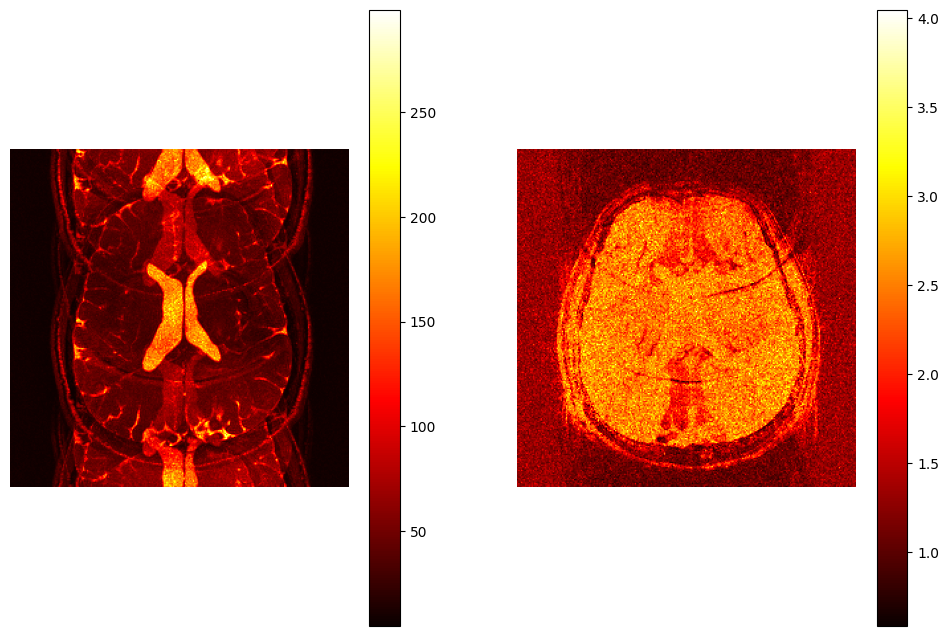

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(np.abs(snrmap),cmap='hot')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(np.abs(gmap),cmap='hot')
plt.colorbar()
plt.axis('off')
plt.show()